%% javascript MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber: "AMS" } } });

### Time-optimal control of a Double Integral Plant

We shall analytically and approximately (via the level set toolbox and the PGD scheme we describe) solve for the 

+ Terminal state of the origin of the state plane when:

  + The Target set is an entire axis

  + The Target set is a line segment

The double integral plant can represent the load in a frictionless and an environment where gravity is non-existent, for example. While this makes no engineering sense, it is useful for didactic purposes in analysing the large-scale system dynamics of interest to us.

Suppose we let $m$ be the mass (or inertial momentum) of a body, $x(t)$ the position (or angular displacement), and $\tau(t)$ the applied torque, then by Newton's second law of motion, we have 

\begin{align}
    m \ddot{x}(t) = \tau(t).
\end{align}

Let us write $u(t) = \tau(t)/m$, so that we have

\begin{align}
  \ddot{x}(t) = u(t).
\end{align}

If we consider the following change of variables,

\begin{align}
  {x}_1(t) &= x(t) \\
  {x}_2(t) &= \dot{x}(t),
\end{align}

we can then represent the system as the following system of first-order o.d.e's:

\begin{align}
  \dot{x}_1(t) &= x_2(t) \\
  \dot{x}_2(t) &= u(t).
\end{align}

Let $u(t)$ be bounded as follows $|u(t)| \le 1$ for all $t$. This is as a result of limitations on the amount of effort we want to give to our actuator. We now redefine the problem to be solved as follows:

\begin{align}
  \dot{x}_1(t) &= x_2(t) \\
  \dot{x}_2(t) &= u(t) \qquad \qquad |u(t)| \le 1.
\end{align}

The statement of the problem at hand is to _find an admissible control that forces the above system from any initial state $\left[\xi_1, \xi_2\right]$ to the origin (0,0) in the shortest possible time._

In [1]:
import copy
import cupy as cp
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import sys
from os.path import abspath, join
sys.path.append(abspath(join('..')))
from BRATVisualization.DIVisu import DoubleIntegratorVisualizer
sys.path.append(abspath(join('../..')))
from LevelSetPy.Utilities import *
from LevelSetPy.POD import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF
from LevelSetPy.ExplicitIntegration.Integration import odeCFL2, odeCFLset
from LevelSetPy.ExplicitIntegration.Term import termRestrictUpdate, termLaxFriedrichs

In [14]:
gmin = np.array(([[-1, -1]]),dtype=np.float64).T
gmax = np.array(([[1, 1]]),dtype=np.float64).T
g = createGrid(gmin, gmax, 101, None)

eps_targ = 1.0
u_bound = 1
target_rad = .2 #eps_targ * np.max(g.dx)
dint = DoubleIntegrator(g, u_bound)
attr = dint.mttr() - target_rad

value_func = copy.copy(attr)
value_func_init = copy.copy(value_func)

attr = np.maximum(0, attr)


#### Trajectories in the $x_1$-$x_2$ plane

\begin{align}
x_1 &= \xi_1 + \frac{1}{2} \Delta x_2^2 - \frac{1}{2} \Delta \xi_2^2, \text{ where } \quad t = \Delta(x_2 - \xi_2)  \\
x_2 &= \xi_2 + \Delta t
\end{align}

where $\Delta$ = $+1$ or $-1$, $t$ is the time it takes to arribve at our goal and $x_1$ and $x_2$ are the position and velocity respectively.

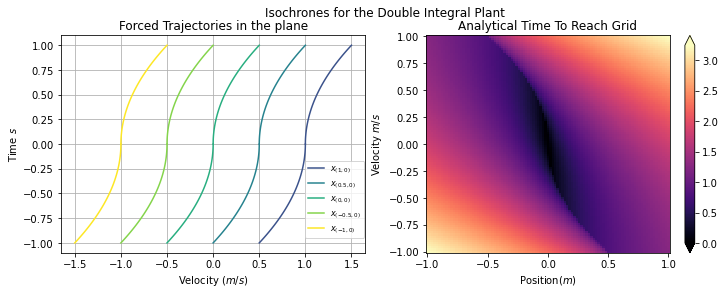

In [15]:
### pick a bunch of initial conditions
Delta = lambda u: u  # u is either +1 or -1
xis = [(1,0), (.5, 0),  (0,0), (-.5, 0), (-1,0)]

# how much timesteps to consider
t = np.linspace(0, 1, 100)
u = 1
# do implicit euler integration to obtain x1 and x2
x1p = np.empty((len(xis), g.xs[0].shape[1], len(t)))
x2p = np.empty((len(xis), g.xs[1].shape[1], len(t)))

# for -ve control input
x1m = np.empty((len(xis), g.xs[0].shape[1], len(t)))
x2m = np.empty((len(xis), g.xs[1].shape[1], len(t)))

for i in range(len(xis)):
    for k in range(len(t)):
        x2p[i, :,k] = xis[i][1] + Delta(u) * t[k]
        x1p[i, :,k] = xis[i][0] + .5 * Delta(u) * x2p[i,:,k]**2 - .5 * Delta(u) * xis[i][1]**2 
        x2m[i, :,k] = xis[i][1] + Delta(-u) * t[k]
        x1m[i, :,k] = xis[i][0] + .5 * Delta(-u) * x2m[i,:,k]**2 - .5 * Delta(-u) * xis[i][1]**2 
        
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,4))

# Plot a few snapshots.
color = iter(plt.cm.viridis(np.linspace(.25, 1, 5)))
for init_cond in range(len(xis)):
    x1_temp = x1p[init_cond, -1, :] 
    x2_temp = x2p[init_cond, -1, :] 
    color_now=next(color)
    ax1.grid('on')
    ax1.plot(x1_temp, x2_temp, color=color_now)

    x1_temp = x1m[init_cond, -1, :] 
    x2_temp = x2m[init_cond, -1, :] 
    ax1.plot(x1_temp, x2_temp, color=color_now, label=rf"$x_{{{xis[init_cond]}}}$")
#ax1.set_xlim(-1, 1)
#ax1.set_ylim(-1, 1)
ax1.set_xlabel(r"Velocity ($m/s$)")
ax1.set_ylabel(r"Time $s$")
ax1.set_title(r"Forced Trajectories in the plane")
ax1.legend(loc="lower right", fontsize=8, bbox_to_anchor=(1.01,.05))


# Plot all vectograms(snapshots) in space and time.
cdata = ax2.pcolormesh(g.xs[0], g.xs[1], attr, shading="nearest", cmap="magma")
plt.colorbar(cdata, ax=ax2, extend="both")
ax2.set_xlabel(r"Position($m$)")
ax2.set_ylabel(r"Velocity $m/s$")
ax2.set_title(r"Analytical Time To Reach Grid")

fig.suptitle("Isochrones for the Double Integral Plant")
plt.show()


### Examine the Level Sets

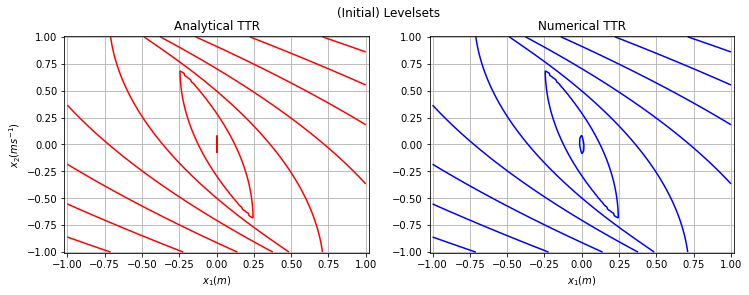

In [23]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))

ax1.contour(g.xs[0], g.xs[1], attr, colors='red')
ax1.set_title('Analytical TTR')
ax1.set_xlabel(r"$x_1 (m)$")
ax1.set_ylabel(r"$x_2 (ms^{-1})$")
ax1.set_xlim([-1.02, 1.02])
ax1.set_ylim([-1.01, 1.01])
ax1.grid()

ax2.contour(g.xs[0], g.xs[1], value0_cpu, colors='blue')
ax2.set_title('Numerical TTR')
ax2.set_xlabel(r"$x_1 (m)$")
ax2.set_xlim([-1.02, 1.02])
ax2.set_ylim([-1.01, 1.01])
ax2.grid()

f.suptitle(f"(Initial) Levelsets")

plt.show()

In [24]:
args = Bundle(dict(elevation=5, azimuth=5, pause_time=1,visualize=True))
#turn the state space over to the gpu
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
			innerData = Bundle({'grid':g, 'hamFunc': dint.hamiltonian,
				'partialFunc': dint.dynamics,
				'dissFunc': artificialDissipationGLF,
				'derivFunc': upwindFirstENO2,
				'input_bound': u_bound,
				'innerFunc': termLaxFriedrichs,
				}),
				positive = False,  # direction to grow the updated level set
			))
small = 100*eps
t_span = np.linspace(0, 2.0, 20)
options = Bundle(dict(factorCFL=0.75, stats='on', maxStep=realmax, \
						singleStep='off', postTimestep=postTimeStepTTR))

y = copy.copy(value_func.flatten())
y, finite_diff_data = postTimeStepTTR(0, y, finite_diff_data)
value_func = cp.asarray(copy.copy(y.reshape(g.shape)))

In [27]:
value0_cpu = value_func.get()
U, Sigma, V = la.svd(value0_cpu, full_matrices=False)

# sanity checks
print(U.shape, Sigma.shape, V.shape)
np.allclose(U@np.diag(Sigma)@V, value0_cpu)

(101, 101) (101,) (101, 101)


True

### Project Value Function Onto Reduced Basis
To project in an informed manner, we choose an approximation error
    $\epsilon$ e.g. 1e-5. 

We can construct a POD basis $V_r$ to use in the construction of the ROM.
There are a few ways to make an informed choice of $r$; in this example, we examine the _projection error_, defined by
$$
\text{err}_\text{projection} = \frac{||X - V_rV_r^\mathsf{T}X||_F}{||X||_F}.
$$
We choose $r$ so that the projection error is under $10^{-5}$.



52


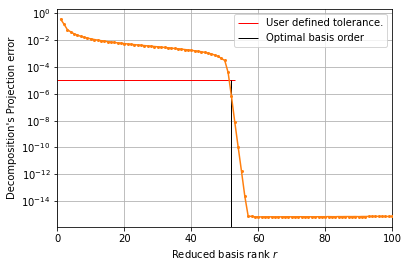

In [28]:
# informed reduced basis rank
min_rank = minimal_projection_error(value0_cpu, U, eps=1e-5, plot=True)
print(min_rank)

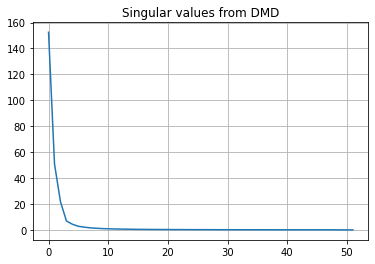

Value function in ROB: (101, 52)


In [36]:
Ur, Sigmar, Vr = U[:,:min_rank], Sigma[:min_rank], V[:,:min_rank]
# be sure the singular values are arranged in descending order
plt.plot(Sigmar)
plt.grid('on')
plt.title('Singular values from DMD')
plt.show()
# project value function in reduced basis
value_rob = Ur.T @ value0_cpu @ Ur
value_rob = value0_cpu @ Ur
print(f'Value function in ROB: {value_rob.shape}')

### Populate the ROB value onto the Big Grid

In [37]:
# Do a least squares fit to the original grid w/L2 regularization
# _UtVr = U.T * value_rob
# _UtVr.shape
λ = .1
_V = V.T
_Σinv = 1/Sigma.reshape(-1, 1)
X = _V @ (_Σinv * value_rob)
print(X.shape)

(101, 52)


In [29]:
vs = [np.arange(1, 6), np.arange(6, 11)]
xs = np.meshgrid(*vs, indexing='ij')
# print(vs)
# print()
# print(xs)
# print()
# data = np.arange(1, 11).reshape(2, 5)
# didx = np.indices(data.shape)
# print(data)
# print()
# print(didx)

In [9]:
g_rom = copy.deepcopy(g)

#Project the state space to this reduced basis
g_rom.xs[0] = g.xs[0][:min_rank, :min_rank]
g_rom.xs[1] = g.xs[1][:min_rank, :min_rank]

g_rom.N = min_rank 
g_rom.shape = g_rom.xs[0].shape

dint_rob = DoubleIntegrator(g_rom, u_bound)
# rom_attr = dint.update_rom(g_rom)
finite_diff_rob = Bundle(dict(innerFunc = termLaxFriedrichs,
			innerData = Bundle({'grid':g_rom, 'hamFunc': dint_rob.hamiltonian,
				'partialFunc': dint_rob.dynamics,
				'dissFunc': artificialDissipationGLF,
				'derivFunc': upwindFirstENO2,
				'input_bound': u_bound,
				'innerFunc': termLaxFriedrichs,
				}),
				positive = False,  # direction to grow the updated level set
			))

# because we are going to 
# test one iter of the rob
# y0_rob = cp.asarray(value_rob.flatten())
# t_span = [0, .25]
# t_rob, y_rob, finite_diff_rob = odeCFL2(termRestrictUpdate, t_span, y0_rob, options, finite_diff_rob)

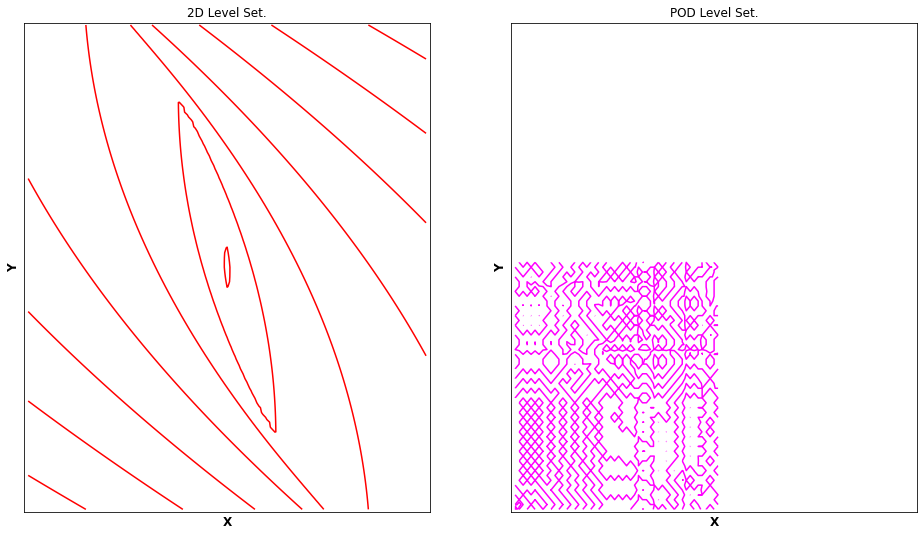

In [10]:

# Visualization paramters
spacing = tuple(g.dx.flatten().tolist())
params = Bundle(
					{'grid': g,
					'pgd_grid': g_rom,
					'disp': True,
					'labelsize': 16,
					'labels': "Initial 0-LevelSet",
					'linewidth': 2,
					'data': value_func,
					'elevation': args.elevation,
					'azimuth': args.azimuth,
					'mesh': value_func.get(),
					'pgd_mesh': value_rob,
					'init_conditions': False,
					'pause_time': args.pause_time,
					'level': 0, # which level set to visualize
					'winsize': (16,9),
					'fontdict': Bundle({'fontsize':12, 'fontweight':'bold'}),
					"savedict": Bundle({"save": False,
								"savename": "rcbrt",
								"savepath": "../jpeg_dumps/rcbrt"})
					})

if args.visualize:
	viz = DoubleIntegratorVisualizer(params)

value_func_all = [value_func]

cur_time, max_time = 0, t_span[-1]
step_time = (t_span[-1]-t_span[0])/8.0

start_time = cputime()
itr_start = cp.cuda.Event()
itr_end = cp.cuda.Event()

+ Interpolate V_rob onto V_max

+ Look into migrate_grid from helperOC

+ Auto Encoder to project orig grid onto reduced grids

+ 

In [12]:
while max_time-cur_time > small * max_time:
	itr_start.record()
	cpu_start = cputime()

	time_step = f"{cur_time:.2f}/{max_time:.2f}"

	y0 = value_func.flatten()
	y0_rob = cp.asarray(value_rob.flatten())

	#How far to integrate
	t_span = np.hstack([cur_time, min(max_time, cur_time + step_time)])

	# advance one step of integration
	t, y, finite_diff_data = odeCFL2(termRestrictUpdate, t_span, y0, options, finite_diff_data)
	t_rob, y_rob, finite_diff_rob = odeCFL2(termRestrictUpdate, t_span, y0_rob, options, finite_diff_rob)
	cp.cuda.Stream.null.synchronize()
	cur_time = t if np.isscalar(t) else t[-1]

	value_func = cp.reshape(y, g.shape)
	value_rob = cp.reshape(y_rob, g_rom.shape)

	if args.visualize:
		ls_mesh = value_func.get()
		pgd_mesh = value_rob.get()
		viz.update_tube(ls_mesh, attr, ls_mesh, pgd_mesh, cur_time, delete_last_plot=False)
	
	itr_end.record()
	itr_end.synchronize()
	cpu_end = cputime()
	
	print(f't: {time_step} | GPU time: {(cp.cuda.get_elapsed_time(itr_start, itr_end)):.2f} | CPU Time: {(cpu_end-cpu_start):.2f}')
	print(f'Bnds {min(y):.2f}/{max(y):.2f} | PGD Bnds {min(y_rob):.2f}/{max(y_rob):.2f} | Norm: {np.linalg.norm(y, 2):.2f} | PGD Norm: {np.linalg.norm(y_rob, 2):.2f} ')
	
	# store this brt
	value_func_all.append(ls_mesh)
	value_func_all.append(pgd_mesh)
		
end_time = cputime()
print(f'Total BRS/BRT execution time {(end_time - start_time):.4f} seconds.')

t: 0.00/2.00 | GPU time: 3424.79 | CPU Time: 3.42
Bnds -0.20/3.01 | PGD Bnds -180.42/-0.00 | Norm: 140.07 | PGD Norm: 1359.68 
t: 0.25/2.00 | GPU time: 3163.26 | CPU Time: 3.16
Bnds -0.20/2.78 | PGD Bnds -378.74/-0.00 | Norm: 118.88 | PGD Norm: 4939.65 
t: 0.50/2.00 | GPU time: 3157.48 | CPU Time: 3.16
Bnds -0.20/2.55 | PGD Bnds -605.06/-0.02 | Norm: 99.14 | PGD Norm: 10859.33 
t: 0.75/2.00 | GPU time: 3038.81 | CPU Time: 3.04
Bnds -0.20/2.30 | PGD Bnds -857.62/-0.05 | Norm: 81.05 | PGD Norm: 19341.03 
t: 1.00/2.00 | GPU time: 2965.62 | CPU Time: 2.97
Bnds -0.20/2.05 | PGD Bnds -1134.66/-0.14 | Norm: 64.92 | PGD Norm: 30015.26 
t: 1.25/2.00 | GPU time: 3089.09 | CPU Time: 3.09
Bnds -0.20/1.80 | PGD Bnds -1434.43/-30.30 | Norm: 51.02 | PGD Norm: 42531.41 
t: 1.50/2.00 | GPU time: 3059.77 | CPU Time: 3.06
Bnds -0.20/1.55 | PGD Bnds -1755.17/-250.79 | Norm: 39.52 | PGD Norm: 56646.83 
t: 1.75/2.00 | GPU time: 3071.46 | CPU Time: 3.07
Bnds -0.20/1.29 | PGD Bnds -2095.14/-516.19 | Norm: 30.

In [13]:
while max_time-cur_time > small * max_time:
	itr_start.record()
	cpu_start = cputime()

	time_step = f"{cur_time:.2f}/{max_time:.2f}"

	y0 = value_func.flatten()

	#How far to integrate
	t_span = np.hstack([cur_time, min(max_time, cur_time + step_time)])

	# one step of integration
	t, y, finite_diff_data = odeCFL2(termRestrictUpdate, t_span, y0, options, finite_diff_data)
	cp.cuda.Stream.null.synchronize()
	cur_time = t if np.isscalar(t) else t[-1]

	value_func = cp.reshape(y, g.shape)

	if args.visualize:
		data_np = value_func.get()
		mesh=implicit_mesh(data_np, level=0, spacing=spacing,
							edge_color='None',  face_color='red')
		viz.update_tube(data_np, mesh, args.pause_time)
	
	itr_end.record()
	itr_end.synchronize()
	cpu_end = cputime()
	
	info(f't: {time_step} | GPU time: {(cp.cuda.get_elapsed_time(itr_start, itr_end)):.2f} | CPU Time: {(cpu_end-cpu_start):.2f}, | Targ bnds {min(y):.2f}/{max(y):.2f} Norm: {np.linalg.norm(y, 2):.2f}')
	
	# store this brt
	value_func_all.append(value_func.get())
		
	end_time = cputime()
	info(f'Total BRS/BRT execution time {(end_time - start_time):.4f} seconds.')